## Multi-classification based One-vs-All Logistic Regression 

###Building one-vs-all logistic regression classifiers to distinguish ten objects in [CIFAR-10 dataset](http://www.cs.toronto.edu/~kriz/cifar.html), the binary logistic classifier implementation is [here](http://houxianxu.github.io/implementation/LogisticRegression.html).

Most of the codes are copied from binary logistic implementation to make this notebook self-contained.

- implement a fully-vectorized **loss function** for the Logistic Regression
- implement the fully-vectorized expression for its **analytic gradient**
- **check implementation** using **numerical gradient**
- **optimize** the loss function with **Batch Gradient Descent** and **Stochastic Gradient Descent**

In [1]:
# Setup code for this notebook
import random 
import numpy as np
import matplotlib.pyplot as plt

# This is a bit of magic gto make matplotlib figures appear inline
# in the notebook rather than in a new window
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

### Download CIFAR-10 Data
I use the loading function from [course code](http://cs231n.github.io/assignment1/) from Stanford University

Run get_datasets.sh in terminal to download the datasets, or download from [Alex Krizhevsky](http://www.cs.toronto.edu/~kriz/cifar.html).

>get_datasets.sh
>``` bash
># Get CIFAR10
>wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
>tar -xzvf cifar-10-python.tar.gz
>rm cifar-10-python.tar.gz 
```

The results of the downloading is showed in following figure.

<img style="float: left" src="images/cifar-10.png">

## Write function to load data in data_utils.py

In [2]:
# Write function to load the cifar-10 data
# The original code is from http://cs231n.github.io/assignment1/
# The function is in data_utils.py file for reusing.
import pickle as pickle
import numpy as np
import os

def load_CIFAR_batch(filename):
  """ load single batch of cifar """
  with open(filename, 'r') as f:
    datadict = pickle.load(f)
    X = datadict['data']
    Y = datadict['labels']
    X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
    Y = np.array(Y)
    return X, Y

def load_CIFAR10(ROOT):
  """ load all of cifar """
  xs = []
  ys = []
  for b in range(1,6):
    f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
    X, Y = load_CIFAR_batch(f)
    xs.append(X)
    ys.append(Y)    
  Xtr = np.concatenate(xs)
  Ytr = np.concatenate(ys)
  del X, Y
  Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
  return Xtr, Ytr, Xte, Yte

## Load data and visualize some samples

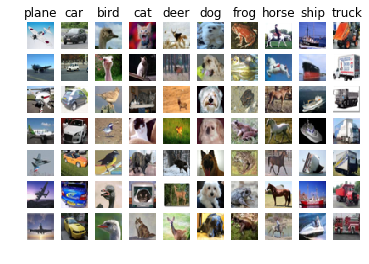

Train data shape:  (3073, 49000)
Train labels shape:  (49000,)
Validation data shape:  (3073, 1000)
Validation labels shape:  (1000,)
Test data shape:  (3073, 10000)
Test labels shape:  (10000,)


In [3]:
from algorithms.data_utils import load_CIFAR10
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def get_CIFAR10_data(num_training=49000, num_val=1000, num_test=10000, show_sample=True):
    """
    Load the CIFAR-10 dataset, and divide the sample into training set, validation set and test set
    """

    cifar10_dir = 'datasets/datasets-cifar-10/cifar-10-batches-py/'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # subsample the data for validation set
    mask = range(num_training, num_training + num_val)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]
    return X_train, y_train, X_val, y_val, X_test, y_test

def visualize_sample(X_train, y_train, classes, samples_per_class=7):
    """visualize some samples in the training datasets """
    num_classes = len(classes)
    for y, cls in enumerate(classes):
        idxs = np.flatnonzero(y_train == y) # get all the indexes of cls
        idxs = np.random.choice(idxs, samples_per_class, replace=False)
        for i, idx in enumerate(idxs): # plot the image one by one
            plt_idx = i * num_classes + y + 1 # i*num_classes and y+1 determine the row and column respectively
            plt.subplot(samples_per_class, num_classes, plt_idx)
            plt.imshow(X_train[idx].astype('uint8'))
            plt.axis('off')
            if i == 0:
                plt.title(cls)
    plt.show()
    
def preprocessing_CIFAR10_data(X_train, y_train, X_val, y_val, X_test, y_test):
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1)) # [49000, 3072]
    X_val = np.reshape(X_val, (X_val.shape[0], -1)) # [1000, 3072]
    X_test = np.reshape(X_test, (X_test.shape[0], -1)) # [10000, 3072]
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    
    # Add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))]).T
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))]).T
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))]).T
    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above functions to get our data
X_train_raw, y_train_raw, X_val_raw, y_val_raw, X_test_raw, y_test_raw = get_CIFAR10_data()
visualize_sample(X_train_raw, y_train_raw, classes)

X_train, y_train, X_val, y_val, X_test, y_test = preprocessing_CIFAR10_data(X_train_raw, y_train_raw, X_val_raw, y_val_raw, X_test_raw, y_test_raw)

# As a sanity check, we print out th size of the training and test data dimenstion
print ('Train data shape: ', X_train.shape)
print ('Train labels shape: ', y_train.shape)
print ('Validation data shape: ', X_val.shape)
print ('Validation labels shape: ', y_val.shape)
print ('Test data shape: ', X_test.shape)
print ('Test labels shape: ', y_test.shape)

## One-vs-All Logisic Regression Classifier for Multi-classification 
The code is running in the backend, you can find it [here](http://houxianxu.github.io/logistic-softmax-regression/), or [github](https://github.com/houxianxu/houxianxu.github.io/tree/master/implementation)

The basic idea is to change multiple classes into two classes, and construct one logistic classifier for each class. We set the value of y (label) of one class to 1, and 0 for other classes. 

##  Firstly test the gradient and loss function

In [4]:
# Set the label of the first class to be one, and 0 for others
from copy import deepcopy
y_train_test_loss = deepcopy(y_train)
idxs_zero = y_train_test_loss == 0
y_train_test_loss[idxs_zero] = 1
y_train_test_loss[~idxs_zero] = 0

# Test the loss and gradient and compare between two implementations
from algorithms.classifiers import loss_grad_logistic_naive, loss_grad_logistic_vectorized
import time

# generate a rand weights W 
W = np.random.randn(1, X_train.shape[0]) * 0.001
tic = time.time()
loss_naive, grad_naive = loss_grad_logistic_naive(W, X_train, y_train_test_loss, 0)
toc = time.time()
print ('Naive loss: %f, and gradient: computed in %fs' % (loss_naive, toc - tic))

tic = time.time()
loss_vec, grad_vect = loss_grad_logistic_vectorized(W, X_train, y_train_test_loss, 0)
toc = time.time()
print ('Vectorized loss: %f, and gradient: computed in %fs' % (loss_vec, toc - tic))

# Compare the gradient, because the gradient is a vector, we canuse the Frobenius norm to compare them
# the Frobenius norm of two matrices is the square root of the squared sum of differences of all elements
diff = np.linalg.norm(grad_naive - grad_vect, ord='fro')
# Randomly choose some gradient to check
idxs = np.random.choice(X_train.shape[0], 10, replace=False)
print (idxs)
print (grad_naive[0, idxs])
print (grad_vect[0, idxs])
print ('Gradient difference between naive and vectorized version is: %f' % diff)
del loss_naive, loss_vec, grad_naive, y_train_test_loss

Naive loss: 1.697076, and gradient: computed in 70.736746s
Vectorized loss: 1.697076, and gradient: computed in 0.148847s
[ 411 2825 2198  994  205  670  509 1227 2254  299]
[ -8.27399016   5.27986344   1.47321289  -5.79436664 -10.14931642
 -10.484043   -13.55787134  -2.18659626   5.77991135 -13.6527427 ]
[ -8.27399016   5.27986344   1.47321289  -5.79436664 -10.14931642
 -10.484043   -13.55787134  -2.18659626   5.77991135 -13.6527427 ]
Gradient difference between naive and vectorized version is: 0.000000


## Write function to compute gradient numerically for test the analytic gradient
And put the function in algorithms/gradient_check.py file for future use

In [5]:
# file: algorithms/gradient_check.py
def grad_check_sparse(f, x, analytic_grad, num_checks):
  """
  sample a few random elements and only return numerical
  in this dimensions.
  """
  h = 1e-5

  print (x.shape)

  for i in xrange(num_checks):
    ix = tuple([randrange(m) for m in x.shape])
    print (ix)
    x[ix] += h # increment by h
    fxph = f(x) # evaluate f(x + h)
    x[ix] -= 2 * h # increment by h
    fxmh = f(x) # evaluate f(x - h)
    x[ix] += h # reset

    grad_numerical = (fxph - fxmh) / (2 * h)
    grad_analytic = analytic_grad[ix]
    rel_error = abs(grad_numerical - grad_analytic) / (abs(grad_numerical) + abs(grad_analytic))
    print ('numerical: %f analytic: %f, relative error: %e' % (grad_numerical, grad_analytic, rel_error))
    
# Check gradient using numerical gradient along several randomly chosen dimenstion
from algorithms.gradient_check import grad_check_sparse
f = lambda w: loss_grad_logistic_vectorized(w, X_train, y_train, 0)[0]
grad_numerical = grad_check_sparse(f, W, grad_vect, 10)

(1, 3073)
(0, 168)
numerical: -20.805832 analytic: -9.898455, relative error: 3.552395e-01
(0, 989)
numerical: -0.772220 analytic: -8.944090, relative error: 8.410467e-01
(0, 2312)
numerical: 23.729544 analytic: 3.942140, relative error: 7.150777e-01
(0, 2231)
numerical: 28.911700 analytic: 5.992525, relative error: 6.566304e-01
(0, 1276)
numerical: 3.877486 analytic: -2.606306, relative error: 1.000000e+00
(0, 1386)
numerical: -6.642104 analytic: 0.027543, relative error: 1.000000e+00
(0, 1732)
numerical: 15.255827 analytic: 2.690004, relative error: 7.002085e-01
(0, 1766)
numerical: 9.638922 analytic: 2.126306, relative error: 6.385440e-01
(0, 380)
numerical: -25.292618 analytic: -15.033827, relative error: 2.543937e-01
(0, 965)
numerical: -2.419921 analytic: -8.722028, relative error: 5.656198e-01


## Set up and train 10 logistic classifier

In [6]:
# train 10 logistic classifier
from algorithms.classifiers import Logistic

logistic_classifiers = []
num_classes = np.max(y_train) + 1
losses = []
for i in range(num_classes):
    print ('\nThe %d/%dth logistic classifier training...' % (i+1, num_classes))
    y_train_logistic = deepcopy(y_train)
    idxs_i = y_train_logistic == i
    y_train_logistic[idxs_i] = 1
    y_train_logistic[~idxs_i] = 0
    logistic = Logistic()
    loss = logistic.train(X_train, y_train_logistic, method='sgd', batch_size=200, learning_rate=1e-6,
              reg = 1e3, num_iters=1000, verbose=True, vectorized=True)
    losses.append(loss)
    logistic_classifiers.append(logistic)



The 1/10th logistic classifier training...
iteration 0/1000: loss 3.406510
iteration 100/1000: loss 2.040994
iteration 200/1000: loss 1.760488
iteration 300/1000: loss 1.461710
iteration 400/1000: loss 1.353283
iteration 500/1000: loss 1.147142
iteration 600/1000: loss 1.115933
iteration 700/1000: loss 1.018335
iteration 800/1000: loss 0.916793
iteration 900/1000: loss 0.866093

The 2/10th logistic classifier training...
iteration 0/1000: loss 3.312754
iteration 100/1000: loss 2.094670
iteration 200/1000: loss 1.766938
iteration 300/1000: loss 1.480366
iteration 400/1000: loss 1.364412
iteration 500/1000: loss 1.212842
iteration 600/1000: loss 1.105169
iteration 700/1000: loss 1.016235
iteration 800/1000: loss 0.958068
iteration 900/1000: loss 0.882492

The 3/10th logistic classifier training...
iteration 0/1000: loss 2.969720
iteration 100/1000: loss 2.033253
iteration 200/1000: loss 1.699752
iteration 300/1000: loss 1.533721
iteration 400/1000: loss 1.377561
iteration 500/1000: loss

## Prediction by using trained 10 logistic classifiers
Choose the class with the largest score

In [7]:
# Compute the accuracy of training data and validation data
def predict_one_vs_all(logistic_classifiers, X, num_classes):
    scores = np.zeros((num_classes, X.shape[1]))
    for i in range(num_classes):
        logistic = logistic_classifiers[i]
        scores[i, :] = logistic.predict(X)[1]
    pred_X = np.argmax(scores, axis=0)
    return pred_X

pred_train_one_vs_all = predict_one_vs_all(logistic_classifiers, X_train, num_classes)
pred_val_one_vs_all = predict_one_vs_all(logistic_classifiers, X_val, num_classes)
pred_test_one_vs_all = predict_one_vs_all(logistic_classifiers, X_test, num_classes)
print ('Training dataset accuracy: %f' % (np.mean(y_train == pred_train_one_vs_all)))
print ('Validation dataset accuracy: %f' % (np.mean(y_val == pred_val_one_vs_all)))
print ('Test datast accuracy: %f' % (np.mean(y_test == pred_test_one_vs_all)))

Training dataset accuracy: 0.344469
Validation dataset accuracy: 0.325000
Test datast accuracy: 0.331800


## A little summary 
* The accuracy for test dataset can reach 33.40%, which is acceptable when compared with randomly chosing (10.00%)
* The performance could be improved to tune learning rate and regularization strength by validation datasets
* Noctice that we don't directly use the final prediction of logistic regression classifier, instead using the scores for multi-classification. Because there is a potential problem that one sample might be classified to several classes or non-class by fully using logistic regression prediction

### Test

In [17]:
num_classes

10

In [25]:
logistic_classifiers[0].predict(X_train)[1]

array([0.29622441, 0.42167764, 0.63169347, ..., 0.50389439, 0.38519918,
       0.59406724])

In [26]:
import numpy as np
a = np.array([
              [
                  [1, 5, 5, 2],
                  [9, -6, 2, 8],
                  [-3, 7, -9, 1]
              ],

              [
                  [-1, 5, -5, 2],
                  [9, 6, 2, 8],
                  [3, 7, 9, 1]
              ]
            ])

In [28]:
a

array([[[ 1,  5,  5,  2],
        [ 9, -6,  2,  8],
        [-3,  7, -9,  1]],

       [[-1,  5, -5,  2],
        [ 9,  6,  2,  8],
        [ 3,  7,  9,  1]]])

In [27]:
print(np.argmax(a, axis=0))

[[0 0 0 0]
 [0 1 0 0]
 [1 0 1 0]]


In [29]:
# Compute the accuracy of training data and validation data
def predict_one_vs_all(logistic_classifiers, X, num_classes):
    scores = np.zeros((num_classes, X.shape[1]))
    for i in range(num_classes):
        logistic = logistic_classifiers[i]
        scores[i, :] = logistic.predict(X)[1]
    pred_X = np.argmax(scores, axis=0)
    return scores

predict_one_vs_all(logistic_classifiers, X_train, num_classes)


array([[0.29622441, 0.42167764, 0.63169347, ..., 0.50389439, 0.38519918,
        0.59406724],
       [0.58656594, 0.62073869, 0.4473907 , ..., 0.32932618, 0.58488805,
        0.40374267],
       [0.46167726, 0.4619141 , 0.33000658, ..., 0.46296746, 0.52946329,
        0.48046556],
       ...,
       [0.57318008, 0.4620102 , 0.42446007, ..., 0.6082326 , 0.24449025,
        0.48036755],
       [0.30510817, 0.58747722, 0.72314174, ..., 0.36351298, 0.22960363,
        0.75121852],
       [0.43864651, 0.6745484 , 0.77790076, ..., 0.23248741, 0.622466  ,
        0.77765229]])